# 🛰️ EuroSAT Model Evaluation Demo

## One-Click Comprehensive Model Comparison

This notebook evaluates and compares the following models on the **EuroSAT** satellite image classification dataset:

### Classical Machine Learning Models (Trained from scratch - Fast)
- **K-NN** (K-Nearest Neighbors)
- **Random Forest**
- **SVM** (Support Vector Machine)

### Deep Learning Models
- **Simple CNN** (Trained from scratch - Fast)
- **ConvNeXt-Tiny Frozen** (Pre-trained, loaded from file)
- **ConvNeXt-Tiny Fine-tuned** (Pre-trained, loaded from file)
- **ConvNeXt-Small Frozen** (Pre-trained, loaded from file)
- **ConvNeXt-Small Fine-tuned** (Pre-trained, loaded from file)

---

### ⚠️ Prerequisites
Before running this notebook, ensure the following model files are uploaded to `/content/` in Google Colab:
- `best_model_tiny_frozen.pth`
- `best_model_tiny_finetuned.pth`
- `best_model_small_frozen.pth`
- `best_model_small_finetuned.pth`

---

## 📦 Section 1: Setup & Installation

In [2]:
# Install required packages
!pip install timm==0.6.13 --quiet

# Clone ConvNeXt repository for model definitions
import os
if not os.path.exists('ConvNeXt'):
    !git clone https://github.com/facebookresearch/ConvNeXt.git --quiet

# Add ConvNeXt to path
import sys
sys.path.insert(0, 'ConvNeXt')

print("✅ Dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 41.4 MB/s eta 0:00:00
✅ Dependencies installed successfully!


In [3]:
# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import os
import time
import shutil
import random
import ssl
import warnings
from tqdm.notebook import tqdm
from torchvision.datasets.utils import download_url
import models.convnext as convnext

warnings.filterwarnings('ignore')

# Check device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

print("✅ All libraries imported successfully!")

🚀 Running on: cuda
   GPU: Tesla T4
✅ All libraries imported successfully!


## 📥 Section 2: Download & Prepare EuroSAT Dataset

In [4]:
# --- Configuration ---
DATA_DIR = '/content/dataset'
URL = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"

# Bypass SSL Certificate Check
ssl._create_default_https_context = ssl._create_unverified_context

print(f"⬇️ Downloading EuroSAT dataset to {DATA_DIR}...")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Download & Extract
zip_path = os.path.join(DATA_DIR, 'EuroSAT.zip')

if not os.path.exists(zip_path):
    try:
        download_url(URL, DATA_DIR, 'EuroSAT.zip', None)
        print("✅ Download successful.")
    except Exception as e:
        print(f"❌ Standard download failed: {e}")
        import requests
        print("🔄 Attempting fallback download...")
        r = requests.get(URL, verify=False)
        with open(zip_path, 'wb') as f:
            f.write(r.content)
        print("✅ Fallback download successful.")
else:
    print("✅ Dataset already downloaded.")

print("📂 Extracting...")
if not os.path.exists(os.path.join(DATA_DIR, 'train')):
    shutil.unpack_archive(zip_path, DATA_DIR)

    # Re-Organize into Train/Val
    extracted_items = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]
    source_root = os.path.join(DATA_DIR, extracted_items[0])

    train_dir = os.path.join(DATA_DIR, 'train')
    val_dir = os.path.join(DATA_DIR, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    print("🔄 Splitting data into Train (80%) and Val (20%)...")
    classes = os.listdir(source_root)

    for class_name in tqdm(classes, desc="Processing classes"):
        class_path = os.path.join(source_root, class_name)
        if not os.path.isdir(class_path):
            continue

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)
        split_point = int(len(images) * 0.8)

        for img in images[:split_point]:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in images[split_point:]:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

    print("✅ Dataset prepared successfully!")
else:
    print("✅ Dataset already prepared.")

# Display dataset info
train_classes = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print(f"\n📊 Dataset Statistics:")
print(f"   Classes: {len(train_classes)}")
print(f"   Class names: {train_classes}")

⬇️ Downloading EuroSAT dataset to /content/dataset...


100%|██████████| 94.3M/94.3M [00:17<00:00, 5.38MB/s]


✅ Download successful.
📂 Extracting...
🔄 Splitting data into Train (80%) and Val (20%)...


Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Dataset prepared successfully!

📊 Dataset Statistics:
   Classes: 10
   Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## 🎯 Section 3: Define Global Variables & Helper Functions

In [5]:
# --- GLOBAL CONFIGURATION ---
TRAIN_DIR = '/content/dataset/train'
VAL_DIR = '/content/dataset/val'
NUM_CLASSES = 10
BATCH_SIZE = 32
IMG_SIZE_CLASSICAL = 64  # For classical ML models
IMG_SIZE_DL = 224  # For deep learning models

# Model file paths (uploaded to /content/)
MODEL_PATHS = {
    'tiny_frozen': '/content/best_model_tiny_frozen.pth',
    'tiny_finetuned': '/content/best_model_tiny_finetuned.pth',
    'small_frozen': '/content/best_model_small_frozen.pth',
    'small_finetuned': '/content/best_model_small_finetuned.pth',
    'simple_cnn': '/content/best_model_simple_cnn.pth'
}

# Store all results
RESULTS = {}

# --- HELPER FUNCTIONS ---

def load_data_classical(data_dir, img_size=64):
    """Load and flatten images for classical ML models"""
    print(f"📂 Loading data from {data_dir}...")
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for label_idx, class_name in tqdm(enumerate(class_names), total=len(class_names), desc="Classes"):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img.flatten())
                labels.append(label_idx)
    return np.array(images), np.array(labels), class_names


def evaluate_pytorch_model(model, dataloader, device):
    """Evaluate a PyTorch model and return accuracy and predictions"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    confidences = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            top_conf, preds = torch.max(probs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            confidences.extend(top_conf.cpu().numpy())

    accuracy = 100 * correct / total
    avg_confidence = np.mean(confidences) * 100
    return accuracy, avg_confidence, all_preds, all_labels


def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


print("✅ Helper functions defined!")

✅ Helper functions defined!


## 🔬 Section 4: Classical ML Models (K-NN, Random Forest, SVM)

In [6]:
print("="*60)
print("🔬 CLASSICAL MACHINE LEARNING MODELS")
print("="*60)

# Load data for classical models
print("\n--- Loading Data for Classical Models ---")
X_train, y_train, class_names = load_data_classical(TRAIN_DIR, IMG_SIZE_CLASSICAL)
X_val, y_val, _ = load_data_classical(VAL_DIR, IMG_SIZE_CLASSICAL)
print(f"✅ Data Loaded. Train shape: {X_train.shape}, Val shape: {X_val.shape}")

# Preprocessing with PCA
print("\n--- Preprocessing (PCA Dimensionality Reduction) ---")
print("⚙️ Reducing dimensions from 12,288 -> 100 features...")
preprocessor = make_pipeline(StandardScaler(), PCA(n_components=100))
X_train_reduced = preprocessor.fit_transform(X_train)
X_val_reduced = preprocessor.transform(X_val)
print(f"✅ Reduced shape: {X_train_reduced.shape}")

# Define classical models
classical_models = [
    ("K-NN (k=5)", KNeighborsClassifier(n_neighbors=5)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ("SVM (Linear)", LinearSVC(dual='auto', max_iter=5000, random_state=42)),
]

print("\n--- Training & Evaluating Classical Models ---")
classical_results = []

for name, model in classical_models:
    print(f"\n🔄 Training {name}...")
    start_time = time.time()

    model.fit(X_train_reduced, y_train)
    train_time = time.time() - start_time

    # Evaluate
    y_pred = model.predict(X_val_reduced)
    accuracy = accuracy_score(y_val, y_pred) * 100

    RESULTS[name] = {
        'accuracy': accuracy,
        'train_time': train_time,
        'y_pred': y_pred,
        'y_true': y_val
    }

    print(f"   ✅ {name}: Accuracy = {accuracy:.2f}% (Training time: {train_time:.2f}s)")

print("\n" + "="*60)
print("✅ Classical ML Models Complete!")
print("="*60)

🔬 CLASSICAL MACHINE LEARNING MODELS

--- Loading Data for Classical Models ---
📂 Loading data from /content/dataset/train...


Classes:   0%|          | 0/10 [00:00<?, ?it/s]

📂 Loading data from /content/dataset/val...


Classes:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Data Loaded. Train shape: (21600, 12288), Val shape: (5400, 12288)

--- Preprocessing (PCA Dimensionality Reduction) ---
⚙️ Reducing dimensions from 12,288 -> 100 features...
✅ Reduced shape: (21600, 100)

--- Training & Evaluating Classical Models ---

🔄 Training K-NN (k=5)...
   ✅ K-NN (k=5): Accuracy = 45.78% (Training time: 0.02s)

🔄 Training Random Forest...
   ✅ Random Forest: Accuracy = 67.09% (Training time: 7.17s)

🔄 Training SVM (Linear)...
   ✅ SVM (Linear): Accuracy = 39.93% (Training time: 6.52s)

✅ Classical ML Models Complete!


## 🧠 Section 5: Simple CNN (Train from Scratch)

In [7]:
print("="*60)
print("🧠 SIMPLE CNN (Training from Scratch)")
print("="*60)

# Define Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Data Setup for Simple CNN (64x64 resolution)
transform_cnn = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_cnn = datasets.ImageFolder(TRAIN_DIR, transform_cnn)
val_dataset_cnn = datasets.ImageFolder(VAL_DIR, transform_cnn)
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=64, shuffle=False)

# Initialize model
simple_cnn = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=1e-3)

# Training Loop
EPOCHS_CNN = 10
best_acc = 0.0

print(f"\n🔥 Training Simple CNN for {EPOCHS_CNN} epochs...")
start_time = time.time()

for epoch in range(EPOCHS_CNN):
    simple_cnn.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader_cnn, desc=f"Epoch {epoch+1}/{EPOCHS_CNN}", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = simple_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    simple_cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_cnn:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = simple_cnn(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_acc = 100 * correct / total
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(simple_cnn.state_dict(), MODEL_PATHS['simple_cnn'])

    print(f"   Epoch {epoch+1}: Loss={running_loss/len(train_loader_cnn):.4f}, Val Acc={epoch_acc:.2f}%")

train_time = time.time() - start_time

# Final Evaluation
simple_cnn.load_state_dict(torch.load(MODEL_PATHS['simple_cnn']))
acc, conf, preds, labels = evaluate_pytorch_model(simple_cnn, val_loader_cnn, DEVICE)

RESULTS['Simple CNN'] = {
    'accuracy': acc,
    'confidence': conf,
    'train_time': train_time,
    'y_pred': preds,
    'y_true': labels
}

print(f"\n✅ Simple CNN: Best Accuracy = {best_acc:.2f}% (Training time: {train_time:.2f}s)")
print("="*60)

🧠 SIMPLE CNN (Training from Scratch)

🔥 Training Simple CNN for 10 epochs...


Epoch 1/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 1: Loss=1.1098, Val Acc=76.20%


Epoch 2/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6684, Val Acc=82.20%


Epoch 3/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 3: Loss=0.5356, Val Acc=79.33%


Epoch 4/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 4: Loss=0.4732, Val Acc=80.70%


Epoch 5/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 5: Loss=0.3834, Val Acc=88.44%


Epoch 6/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 6: Loss=0.3170, Val Acc=87.57%


Epoch 7/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 7: Loss=0.2684, Val Acc=89.70%


Epoch 8/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 8: Loss=0.2231, Val Acc=89.00%


Epoch 9/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 9: Loss=0.2025, Val Acc=91.39%


Epoch 10/10:   0%|          | 0/338 [00:00<?, ?it/s]

   Epoch 10: Loss=0.1679, Val Acc=90.89%


Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]


✅ Simple CNN: Best Accuracy = 91.39% (Training time: 187.05s)


## 🔥 Section 6: ConvNeXt Models (Load Pre-trained Weights)

In [8]:
print("="*60)
print("🔥 CONVNEXT MODELS (Loading Pre-trained Weights)")
print("="*60)

# Data Setup for ConvNeXt (224x224 resolution)
transform_convnext = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset_convnext = datasets.ImageFolder(VAL_DIR, transform_convnext)
val_loader_convnext = DataLoader(val_dataset_convnext, batch_size=BATCH_SIZE, shuffle=False)

# ConvNeXt Model configurations
convnext_configs = [
    ("ConvNeXt-Tiny (Frozen)", "tiny", MODEL_PATHS['tiny_frozen']),
    ("ConvNeXt-Tiny (Fine-tuned)", "tiny", MODEL_PATHS['tiny_finetuned']),
    ("ConvNeXt-Small (Frozen)", "small", MODEL_PATHS['small_frozen']),
    ("ConvNeXt-Small (Fine-tuned)", "small", MODEL_PATHS['small_finetuned']),
]

print("\n⚠️ Checking for model files...")
for name, arch, path in convnext_configs:
    if os.path.exists(path):
        print(f"   ✅ Found: {path}")
    else:
        print(f"   ❌ Missing: {path}")

print("\n--- Evaluating ConvNeXt Models ---")

for name, arch_type, model_path in convnext_configs:
    print(f"\n🔄 Loading {name}...")

    if not os.path.exists(model_path):
        print(f"   ❌ Skipping: Model file not found at {model_path}")
        continue

    try:
        # Initialize architecture
        if arch_type == "tiny":
            model = convnext.convnext_tiny(pretrained=False)
        else:
            model = convnext.convnext_small(pretrained=False)

        # Modify head for 10 classes
        n_inputs = model.head.in_features
        model.head = nn.Linear(n_inputs, NUM_CLASSES)

        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()
        print(f"   ✅ Weights loaded successfully!")

        # Evaluate
        acc, conf, preds, labels = evaluate_pytorch_model(model, val_loader_convnext, DEVICE)

        RESULTS[name] = {
            'accuracy': acc,
            'confidence': conf,
            'y_pred': preds,
            'y_true': labels
        }

        print(f"   📊 {name}: Accuracy = {acc:.2f}%, Confidence = {conf:.2f}%")

    except Exception as e:
        print(f"   ❌ Error loading {name}: {e}")

print("\n" + "="*60)
print("✅ ConvNeXt Models Evaluation Complete!")
print("="*60)

🔥 CONVNEXT MODELS (Loading Pre-trained Weights)

⚠️ Checking for model files...
   ✅ Found: /content/best_model_tiny_frozen.pth
   ✅ Found: /content/best_model_tiny_finetuned.pth
   ✅ Found: /content/best_model_small_frozen.pth
   ✅ Found: /content/best_model_small_finetuned.pth

--- Evaluating ConvNeXt Models ---

🔄 Loading ConvNeXt-Tiny (Frozen)...
   ✅ Weights loaded successfully!


Evaluating:   0%|          | 0/169 [00:00<?, ?it/s]

   📊 ConvNeXt-Tiny (Frozen): Accuracy = 95.89%, Confidence = 92.33%

🔄 Loading ConvNeXt-Tiny (Fine-tuned)...
   ✅ Weights loaded successfully!


Evaluating:   0%|          | 0/169 [00:00<?, ?it/s]

   📊 ConvNeXt-Tiny (Fine-tuned): Accuracy = 99.20%, Confidence = 99.18%

🔄 Loading ConvNeXt-Small (Frozen)...
   ✅ Weights loaded successfully!


Evaluating:   0%|          | 0/169 [00:00<?, ?it/s]

   📊 ConvNeXt-Small (Frozen): Accuracy = 95.48%, Confidence = 91.73%

🔄 Loading ConvNeXt-Small (Fine-tuned)...
   ✅ Weights loaded successfully!


Evaluating:   0%|          | 0/169 [00:00<?, ?it/s]

   📊 ConvNeXt-Small (Fine-tuned): Accuracy = 98.85%, Confidence = 99.20%

✅ ConvNeXt Models Evaluation Complete!


## 📊 Section 7: Results Summary & Comparison

In [9]:
print("="*70)
print("📊 COMPREHENSIVE RESULTS SUMMARY")
print("="*70)

# Create summary table
print("\n{:<35} {:>15} {:>15}".format("Model", "Accuracy (%)", "Type"))
print("-"*70)

# Sort results by accuracy
sorted_results = sorted(RESULTS.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for name, data in sorted_results:
    model_type = "Classical ML" if name in ["K-NN (k=5)", "Random Forest", "SVM (Linear)"] else "Deep Learning"
    print("{:<35} {:>15.2f} {:>15}".format(name, data['accuracy'], model_type))

print("-"*70)

# Best model
best_model = sorted_results[0]
print(f"\n🏆 Best Model: {best_model[0]} with {best_model[1]['accuracy']:.2f}% accuracy")

📊 COMPREHENSIVE RESULTS SUMMARY

Model                                  Accuracy (%)            Type
----------------------------------------------------------------------
ConvNeXt-Tiny (Fine-tuned)                    99.20   Deep Learning
ConvNeXt-Small (Fine-tuned)                   98.85   Deep Learning
ConvNeXt-Tiny (Frozen)                        95.89   Deep Learning
ConvNeXt-Small (Frozen)                       95.48   Deep Learning
Simple CNN                                    91.39   Deep Learning
Random Forest                                 67.09    Classical ML
K-NN (k=5)                                    45.78    Classical ML
SVM (Linear)                                  39.93    Classical ML
----------------------------------------------------------------------

🏆 Best Model: ConvNeXt-Tiny (Fine-tuned) with 99.20% accuracy



📈 Accuracy Comparison Chart


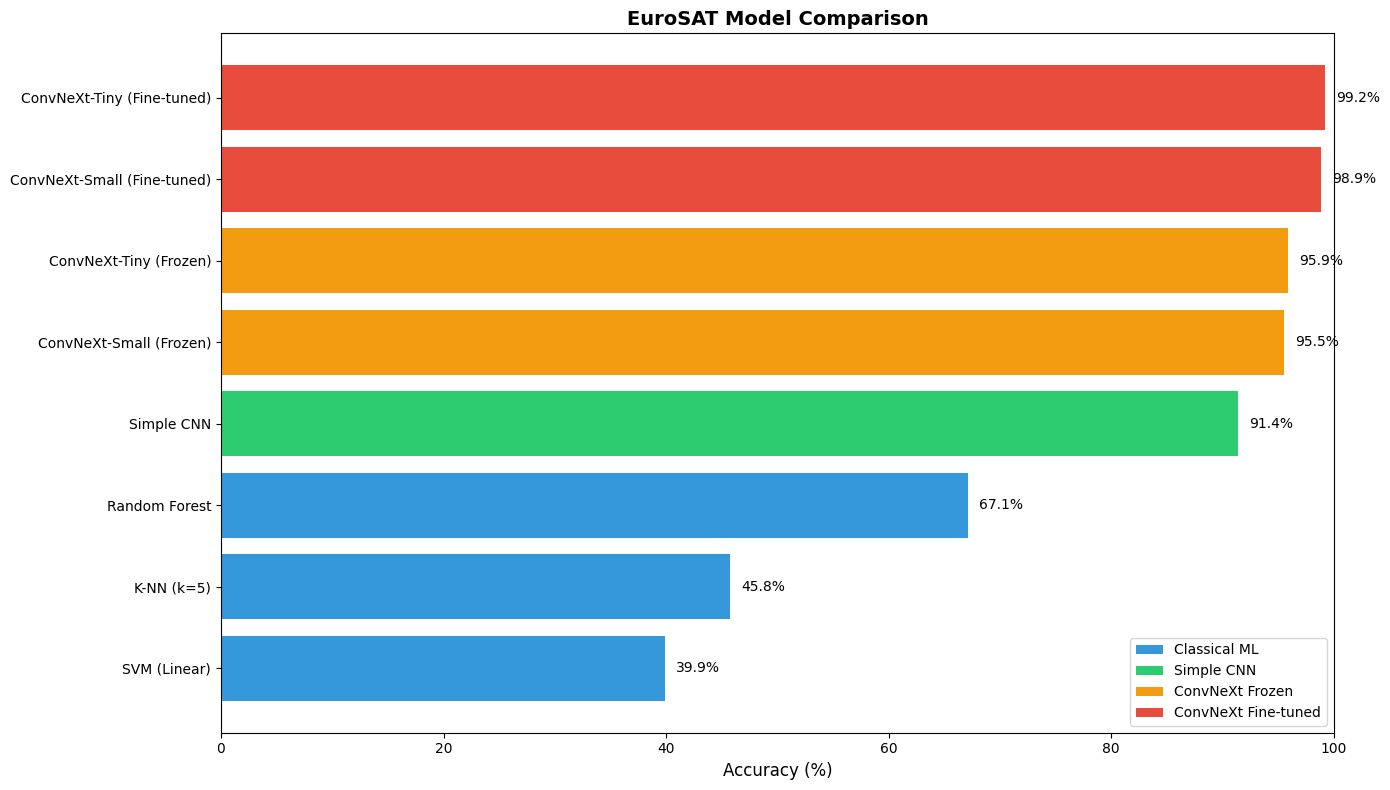

✅ Chart saved to /content/model_comparison.png


In [10]:
# Visualization: Bar Chart Comparison
print("\n📈 Accuracy Comparison Chart")

model_names = [name for name, _ in sorted_results]
accuracies = [data['accuracy'] for _, data in sorted_results]

# Color coding
colors = []
for name in model_names:
    if name in ["K-NN (k=5)", "Random Forest", "SVM (Linear)"]:
        colors.append('#3498db')  # Blue for classical
    elif name == "Simple CNN":
        colors.append('#2ecc71')  # Green for simple CNN
    elif "Frozen" in name:
        colors.append('#f39c12')  # Orange for frozen
    else:
        colors.append('#e74c3c')  # Red for fine-tuned

plt.figure(figsize=(14, 8))
bars = plt.barh(model_names[::-1], accuracies[::-1], color=colors[::-1])
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('EuroSAT Model Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 100)

# Add value labels
for bar, acc in zip(bars, accuracies[::-1]):
    plt.text(acc + 1, bar.get_y() + bar.get_height()/2, f'{acc:.1f}%',
             va='center', fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Classical ML'),
    Patch(facecolor='#2ecc71', label='Simple CNN'),
    Patch(facecolor='#f39c12', label='ConvNeXt Frozen'),
    Patch(facecolor='#e74c3c', label='ConvNeXt Fine-tuned')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Chart saved to /content/model_comparison.png")

## 🔍 Section 8: Confusion Matrices for All Models

🔍 CONFUSION MATRICES

📊 K-NN (k=5)


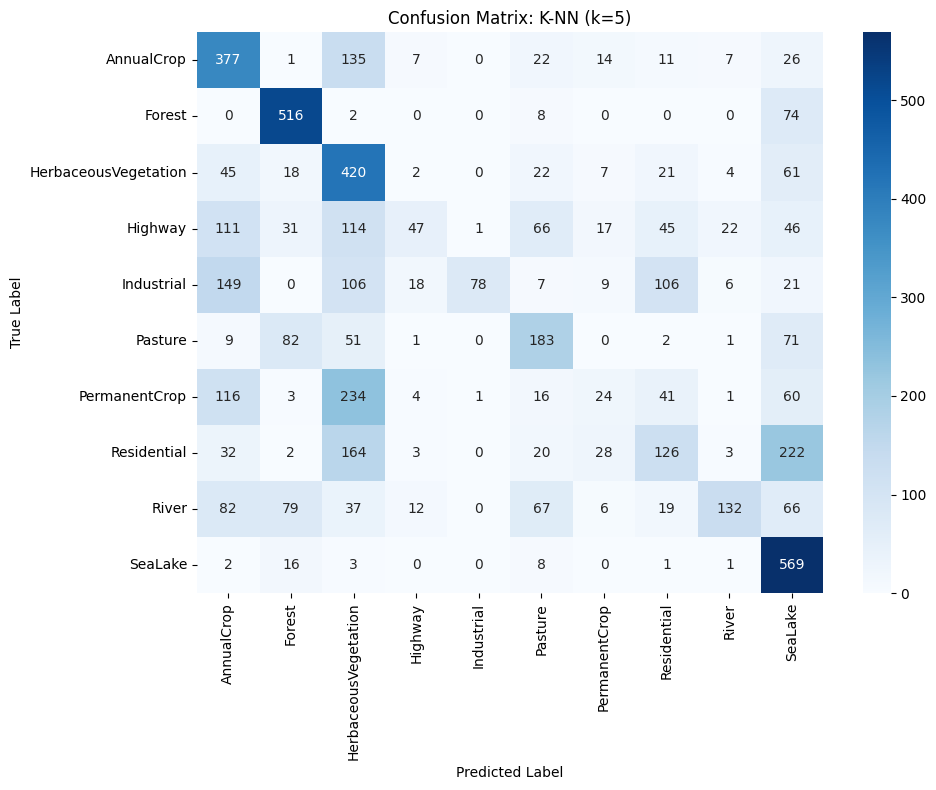


📊 Random Forest


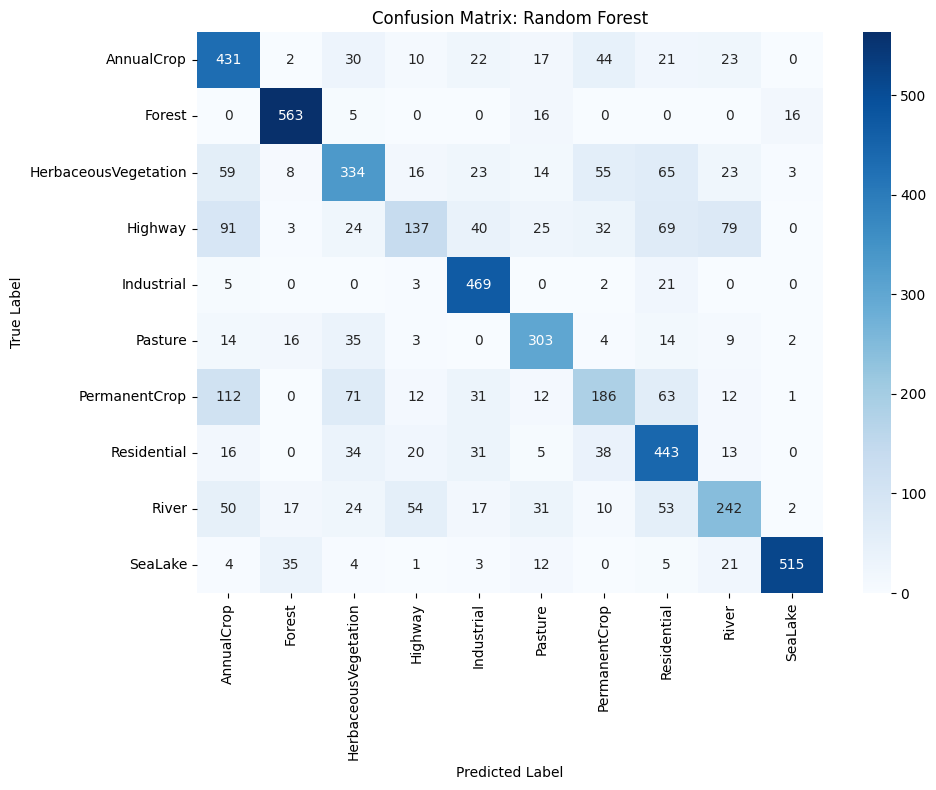


📊 SVM (Linear)


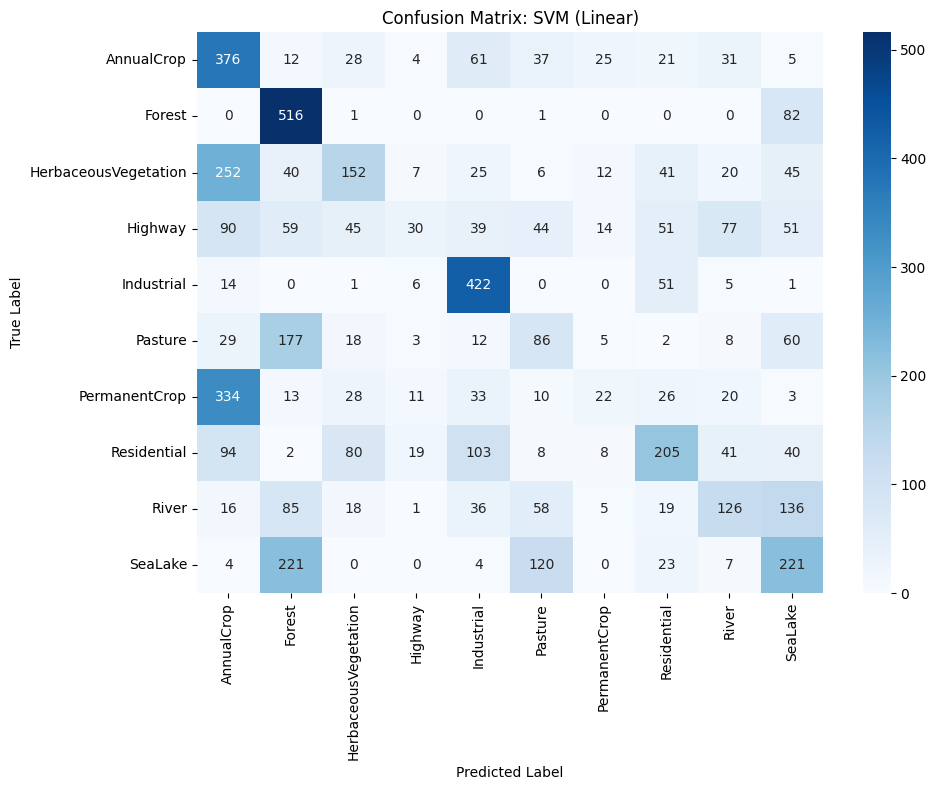


📊 Simple CNN


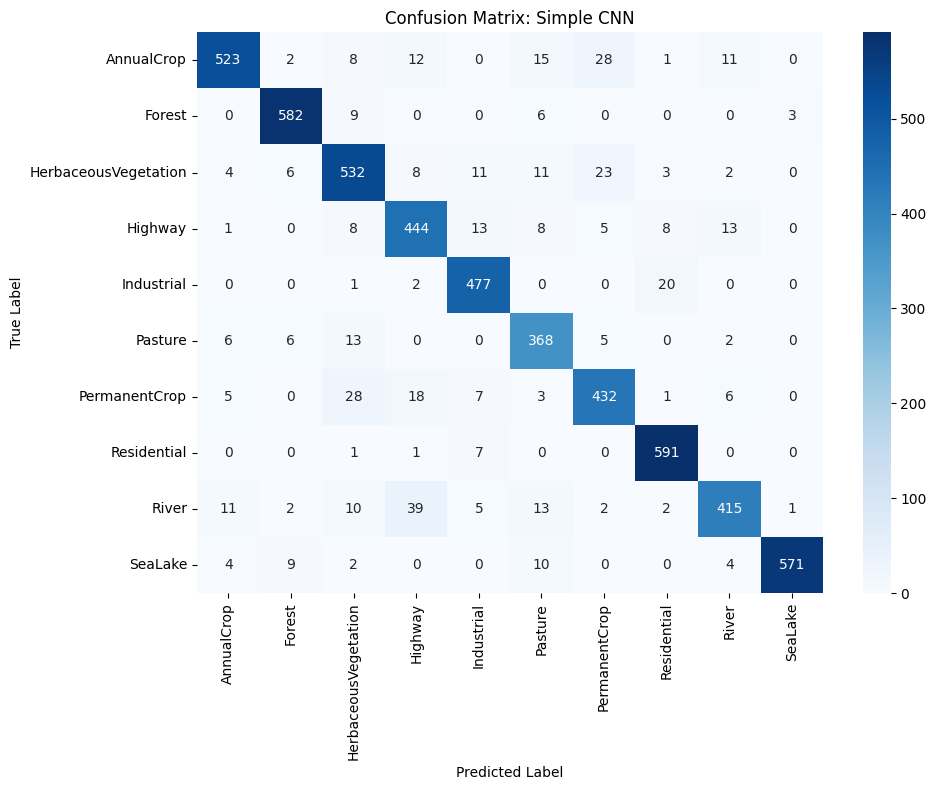


📊 ConvNeXt-Tiny (Frozen)


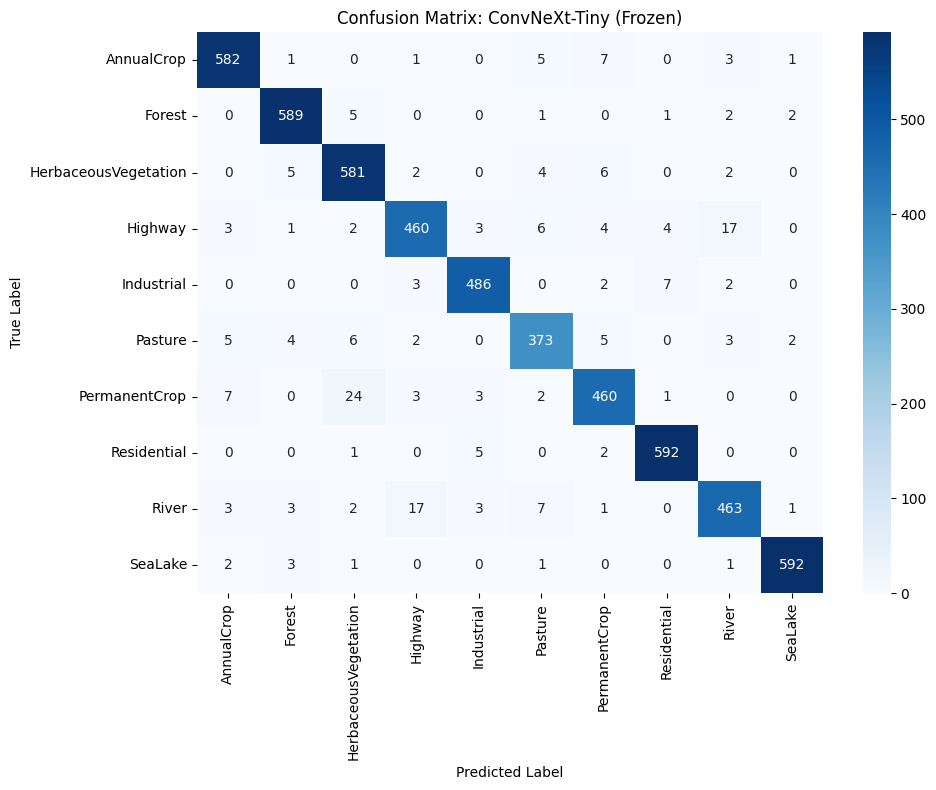


📊 ConvNeXt-Tiny (Fine-tuned)


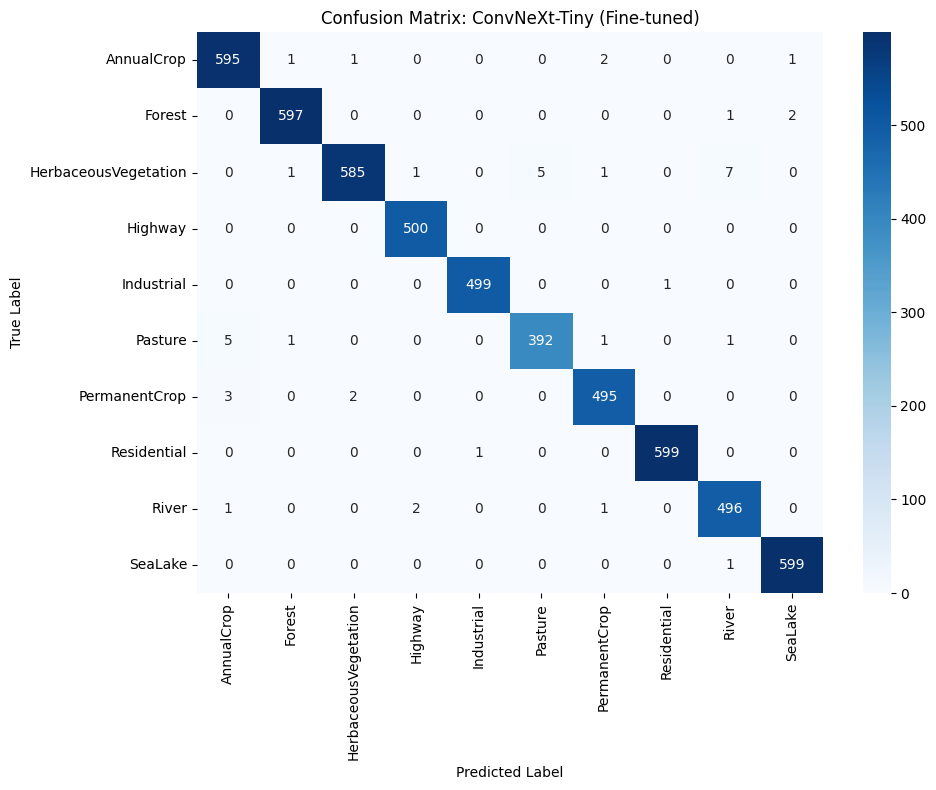


📊 ConvNeXt-Small (Frozen)


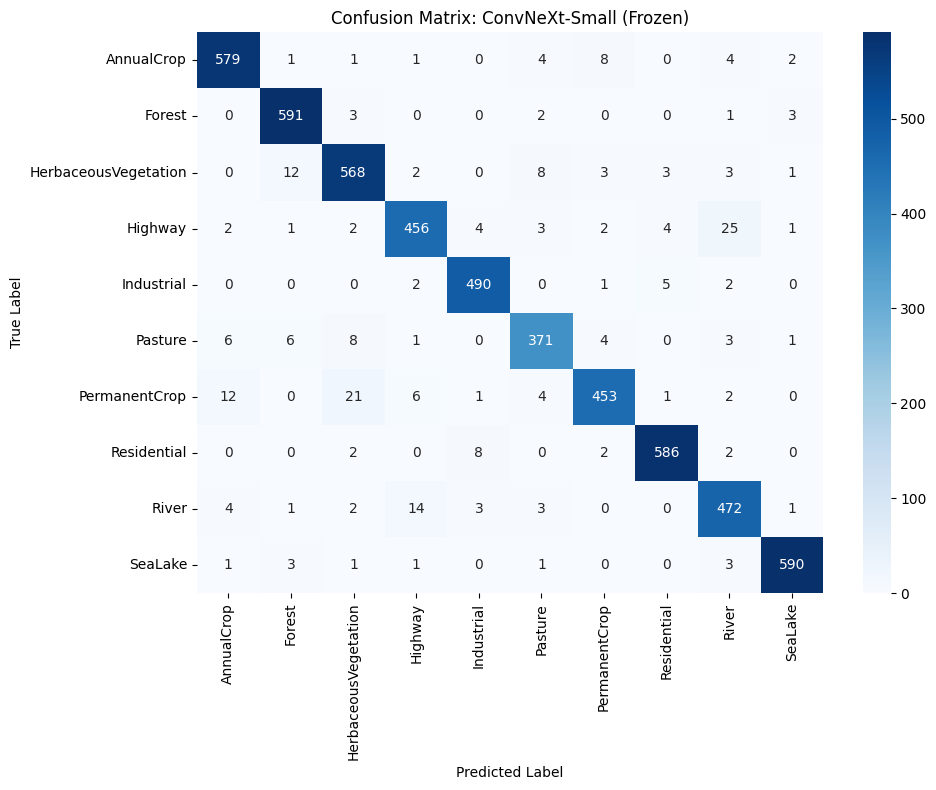


📊 ConvNeXt-Small (Fine-tuned)


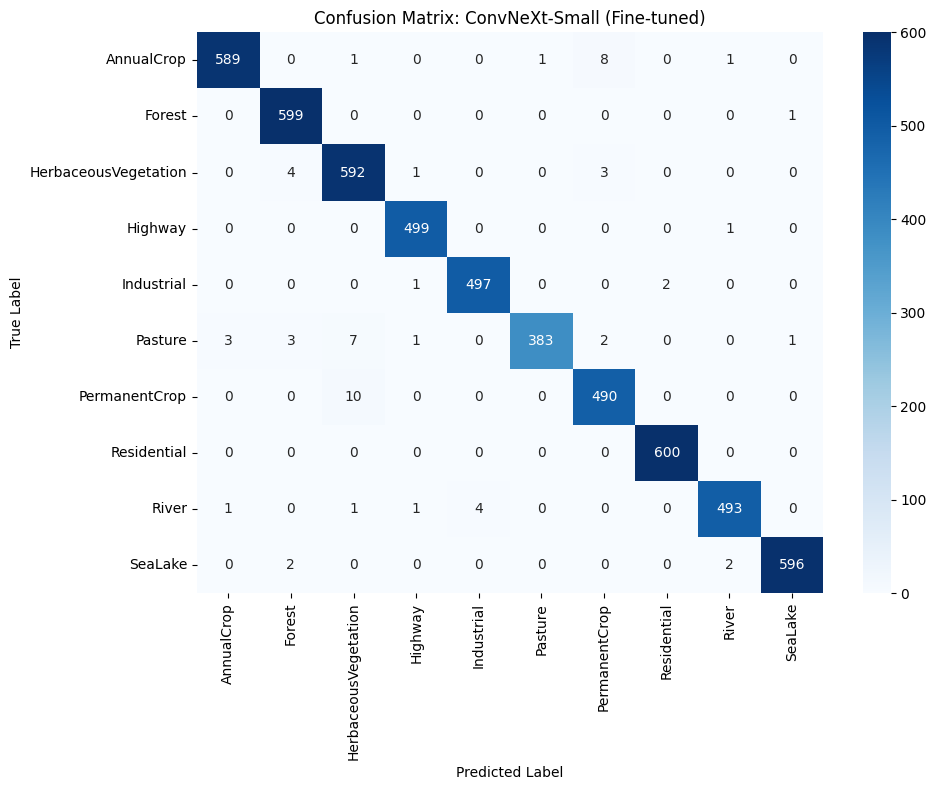

In [11]:
print("="*60)
print("🔍 CONFUSION MATRICES")
print("="*60)

# Get class names
class_names = sorted(os.listdir(VAL_DIR))

# Plot confusion matrices for all models
for name, data in RESULTS.items():
    if 'y_pred' in data and 'y_true' in data:
        print(f"\n📊 {name}")
        plot_confusion_matrix(data['y_true'], data['y_pred'], class_names, f'Confusion Matrix: {name}')

## 📋 Section 9: Detailed Classification Reports

In [12]:
print("="*60)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("="*60)

for name, data in sorted_results[:3]:  # Top 3 models
    if 'y_pred' in data and 'y_true' in data:
        print(f"\n{'='*60}")
        print(f"📊 {name}")
        print("="*60)
        print(classification_report(data['y_true'], data['y_pred'], target_names=class_names))

📋 DETAILED CLASSIFICATION REPORTS

📊 ConvNeXt-Tiny (Fine-tuned)
                      precision    recall  f1-score   support

          AnnualCrop       0.99      0.99      0.99       600
              Forest       0.99      0.99      0.99       600
HerbaceousVegetation       0.99      0.97      0.98       600
             Highway       0.99      1.00      1.00       500
          Industrial       1.00      1.00      1.00       500
             Pasture       0.99      0.98      0.98       400
       PermanentCrop       0.99      0.99      0.99       500
         Residential       1.00      1.00      1.00       600
               River       0.98      0.99      0.99       500
             SeaLake       1.00      1.00      1.00       600

            accuracy                           0.99      5400
           macro avg       0.99      0.99      0.99      5400
        weighted avg       0.99      0.99      0.99      5400


📊 ConvNeXt-Small (Fine-tuned)
                      precision   

## 🎯 Section 10: Final Summary

In [13]:
print("\n" + "="*70)
print("🎯 FINAL EVALUATION SUMMARY")
print("="*70)

print("\n📊 Model Performance Ranking:")
print("-"*70)

for i, (name, data) in enumerate(sorted_results, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{medal} {i}. {name}: {data['accuracy']:.2f}%")

print("\n" + "-"*70)
print("\n📝 Key Observations:")
print("-"*70)

# Calculate improvements
classical_best = max([data['accuracy'] for name, data in RESULTS.items()
                      if name in ["K-NN (k=5)", "Random Forest", "SVM (Linear)"]])

dl_best = max([data['accuracy'] for name, data in RESULTS.items()
               if name not in ["K-NN (k=5)", "Random Forest", "SVM (Linear)"]], default=0)

print(f"\n1. Best Classical ML Accuracy: {classical_best:.2f}%")
print(f"2. Best Deep Learning Accuracy: {dl_best:.2f}%")
if dl_best > 0:
    print(f"3. Deep Learning Improvement: +{dl_best - classical_best:.2f}%")

# Fine-tuning vs Frozen comparison
frozen_models = {name: data for name, data in RESULTS.items() if "Frozen" in name}
finetuned_models = {name: data for name, data in RESULTS.items() if "Fine-tuned" in name}

if frozen_models and finetuned_models:
    frozen_avg = np.mean([data['accuracy'] for data in frozen_models.values()])
    finetuned_avg = np.mean([data['accuracy'] for data in finetuned_models.values()])
    print(f"\n4. Average Frozen Model Accuracy: {frozen_avg:.2f}%")
    print(f"5. Average Fine-tuned Model Accuracy: {finetuned_avg:.2f}%")
    print(f"6. Fine-tuning Improvement: +{finetuned_avg - frozen_avg:.2f}%")

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)


🎯 FINAL EVALUATION SUMMARY

📊 Model Performance Ranking:
----------------------------------------------------------------------
🥇 1. ConvNeXt-Tiny (Fine-tuned): 99.20%
🥈 2. ConvNeXt-Small (Fine-tuned): 98.85%
🥉 3. ConvNeXt-Tiny (Frozen): 95.89%
   4. ConvNeXt-Small (Frozen): 95.48%
   5. Simple CNN: 91.39%
   6. Random Forest: 67.09%
   7. K-NN (k=5): 45.78%
   8. SVM (Linear): 39.93%

----------------------------------------------------------------------

📝 Key Observations:
----------------------------------------------------------------------

1. Best Classical ML Accuracy: 67.09%
2. Best Deep Learning Accuracy: 99.20%
3. Deep Learning Improvement: +32.11%

4. Average Frozen Model Accuracy: 95.69%
5. Average Fine-tuned Model Accuracy: 99.03%
6. Fine-tuning Improvement: +3.34%

✅ EVALUATION COMPLETE!


🌪️ NOISE ROBUSTNESS TEST (Deep Learning Models)

📊 Testing 5 models across 5 noise levels...
----------------------------------------------------------------------

🔄 Testing: Simple CNN


   📊 Simple CNN:   0%|          | 0/5 [00:00<?, ?level/s]

   ✅ Results: ['91.4%', '70.3%', '35.6%', '20.6%', '15.8%']

🔄 Testing: Tiny (Frozen)


   📊 Tiny (Frozen):   0%|          | 0/5 [00:00<?, ?level/s]

   ✅ Results: ['95.9%', '93.1%', '89.5%', '86.7%', '82.7%']

🔄 Testing: Tiny (Fine-Tuned)


   📊 Tiny (Fine-Tuned):   0%|          | 0/5 [00:00<?, ?level/s]

   ✅ Results: ['99.2%', '96.1%', '80.0%', '62.7%', '49.4%']

🔄 Testing: Small (Frozen)


   📊 Small (Frozen):   0%|          | 0/5 [00:00<?, ?level/s]

   ✅ Results: ['95.5%', '92.5%', '90.8%', '87.9%', '85.0%']

🔄 Testing: Small (Fine-Tuned)


   📊 Small (Fine-Tuned):   0%|          | 0/5 [00:00<?, ?level/s]

   ✅ Results: ['98.9%', '90.4%', '75.1%', '60.9%', '48.4%']

📈 GENERATING ROBUSTNESS ANALYSIS GRAPH


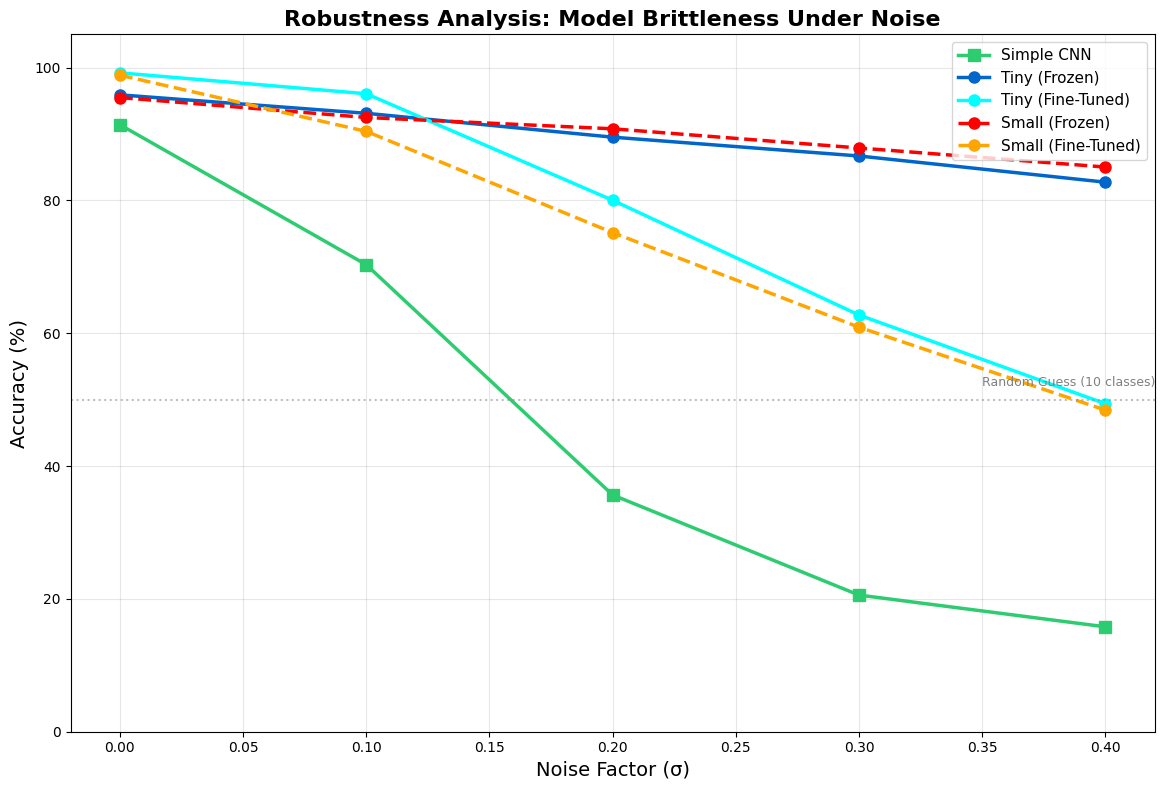


✅ Graph saved to /content/noise_robustness_analysis.png

📊 NOISE ROBUSTNESS RESULTS TABLE
Model                           σ=0.0       σ=0.1       σ=0.2       σ=0.3       σ=0.4   Drop (0→0.4)
----------------------------------------------------------------------------------------------------
Simple CNN                     91.39%      70.31%      35.65%      20.57%      15.80%        -75.59%
Tiny (Frozen)                  95.89%      93.11%      89.52%      86.69%      82.74%        -13.15%
Tiny (Fine-Tuned)              99.20%      96.06%      80.02%      62.74%      49.39%        -49.81%
Small (Frozen)                 95.48%      92.48%      90.78%      87.89%      85.02%        -10.46%
Small (Fine-Tuned)             98.85%      90.39%      75.15%      60.91%      48.43%        -50.43%
----------------------------------------------------------------------------------------------------

🔍 KEY OBSERVATIONS

1. 🏆 Most Robust Model: Small (Frozen)
   - Accuracy drop: 10.46% (from σ=0 to σ

In [14]:
print("="*70)
print("🌪️ NOISE ROBUSTNESS TEST (Deep Learning Models)")
print("="*70)

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Configuration
NOISE_LEVELS = [0.0, 0.1, 0.2, 0.3, 0.4]
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAL_DIR = '/content/dataset/val'

# Base transform (without noise)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(VAL_DIR, base_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Helper function to add Gaussian noise
def add_gaussian_noise(tensor, noise_factor):
    """Add Gaussian noise to tensor"""
    if noise_factor == 0:
        return tensor
    noise = torch.randn_like(tensor) * noise_factor
    return tensor + noise

# Helper function to evaluate with noise
def evaluate_with_noise(model, dataloader, device, noise_factor):
    """Evaluate model with added Gaussian noise"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Add noise to inputs
            inputs = add_gaussian_noise(inputs, noise_factor)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

# Define deep learning models to test
dl_model_configs = [
    ("Simple CNN", "simple_cnn", '/content/best_model_simple_cnn.pth', "simple_cnn"),
    ("Tiny (Frozen)", "tiny", '/content/best_model_tiny_frozen.pth', "convnext"),
    ("Tiny (Fine-Tuned)", "tiny", '/content/best_model_tiny_finetuned.pth', "convnext"),
    ("Small (Frozen)", "small", '/content/best_model_small_frozen.pth', "convnext"),
    ("Small (Fine-Tuned)", "small", '/content/best_model_small_finetuned.pth', "convnext"),
]

# Store results
noise_results = {}

print(f"\n📊 Testing {len(dl_model_configs)} models across {len(NOISE_LEVELS)} noise levels...")
print("-"*70)

for model_name, arch_type, model_path, model_type in dl_model_configs:
    print(f"\n🔄 Testing: {model_name}")

    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"   ❌ Skipping: Model file not found at {model_path}")
        continue

    try:
        # Initialize model architecture
        if model_type == "simple_cnn":
            # Simple CNN architecture (must match the trained model)
            class SimpleCNN(nn.Module):
                def __init__(self):
                    super(SimpleCNN, self).__init__()
                    self.features = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2)
                    )
                    self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(128 * 8 * 8, 256),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(256, 10)
                    )
                def forward(self, x):
                    x = self.features(x)
                    x = self.classifier(x)
                    return x

            model = SimpleCNN()
            # Simple CNN uses 64x64, need different dataloader
            transform_64 = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            dataset_64 = datasets.ImageFolder(VAL_DIR, transform_64)
            test_dataloader = DataLoader(dataset_64, batch_size=BATCH_SIZE, shuffle=False)
        else:
            # ConvNeXt models
            if arch_type == "tiny":
                model = convnext.convnext_tiny(pretrained=False)
            else:
                model = convnext.convnext_small(pretrained=False)

            n_inputs = model.head.in_features
            model.head = nn.Linear(n_inputs, 10)
            test_dataloader = dataloader

        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()

        # Test across noise levels
        accuracies = []
        for noise in tqdm(NOISE_LEVELS, desc=f"   📊 {model_name}", unit="level"):
            acc = evaluate_with_noise(model, test_dataloader, DEVICE, noise)
            accuracies.append(acc)

        noise_results[model_name] = accuracies
        print(f"   ✅ Results: {[f'{a:.1f}%' for a in accuracies]}")

    except Exception as e:
        print(f"   ❌ Error: {e}")

# =============================================================================
# 📈 PLOT: Robustness Analysis Graph
# =============================================================================
print("\n" + "="*70)
print("📈 GENERATING ROBUSTNESS ANALYSIS GRAPH")
print("="*70)

plt.figure(figsize=(12, 8))

# Define colors and styles for each model type
style_config = {
    "Simple CNN": {"color": "#2ecc71", "linestyle": "-", "marker": "s", "linewidth": 2.5},
    "Tiny (Frozen)": {"color": "#0066CC", "linestyle": "-", "marker": "o", "linewidth": 2.5},
    "Tiny (Fine-Tuned)": {"color": "#00FFFF", "linestyle": "-", "marker": "o", "linewidth": 2.5},
    "Small (Frozen)": {"color": "#FF0000", "linestyle": "--", "marker": "o", "linewidth": 2.5},
    "Small (Fine-Tuned)": {"color": "#FFA500", "linestyle": "--", "marker": "o", "linewidth": 2.5},
}

# Plot each model
for model_name, accuracies in noise_results.items():
    style = style_config.get(model_name, {"color": "gray", "linestyle": "-", "marker": "x", "linewidth": 2})
    plt.plot(NOISE_LEVELS, accuracies,
             color=style["color"],
             linestyle=style["linestyle"],
             marker=style["marker"],
             linewidth=style["linewidth"],
             markersize=8,
             label=model_name)

plt.xlabel('Noise Factor (σ)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Robustness Analysis: Model Brittleness Under Noise', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(-0.02, 0.42)
plt.ylim(0, 105)

# Add annotations for key observations
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='_nolegend_')
plt.text(0.35, 52, 'Random Guess (10 classes)', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('/content/noise_robustness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Graph saved to /content/noise_robustness_analysis.png")

# =============================================================================
# 📊 DETAILED RESULTS TABLE
# =============================================================================
print("\n" + "="*70)
print("📊 NOISE ROBUSTNESS RESULTS TABLE")
print("="*70)

# Print header
header = "{:<25}".format("Model")
for noise in NOISE_LEVELS:
    header += "{:>12}".format(f"σ={noise}")
header += "{:>15}".format("Drop (0→0.4)")
print(header)
print("-"*100)

# Print results for each model
for model_name, accuracies in noise_results.items():
    row = "{:<25}".format(model_name)
    for acc in accuracies:
        row += "{:>12}".format(f"{acc:.2f}%")
    # Calculate accuracy drop
    drop = accuracies[0] - accuracies[-1]
    row += "{:>15}".format(f"-{drop:.2f}%")
    print(row)

print("-"*100)

# =============================================================================
# 🔍 KEY OBSERVATIONS
# =============================================================================
print("\n" + "="*70)
print("🔍 KEY OBSERVATIONS")
print("="*70)

if noise_results:
    # Find most robust model (smallest drop)
    drops = {name: accs[0] - accs[-1] for name, accs in noise_results.items()}
    most_robust = min(drops, key=drops.get)
    least_robust = max(drops, key=drops.get)

    print(f"\n1. 🏆 Most Robust Model: {most_robust}")
    print(f"   - Accuracy drop: {drops[most_robust]:.2f}% (from σ=0 to σ=0.4)")

    print(f"\n2. ⚠️  Least Robust Model: {least_robust}")
    print(f"   - Accuracy drop: {drops[least_robust]:.2f}% (from σ=0 to σ=0.4)")

    # Compare frozen vs fine-tuned
    frozen_drops = [v for k, v in drops.items() if "Frozen" in k]
    finetuned_drops = [v for k, v in drops.items() if "Fine-Tuned" in k]

    if frozen_drops and finetuned_drops:
        avg_frozen_drop = np.mean(frozen_drops)
        avg_finetuned_drop = np.mean(finetuned_drops)
        print(f"\n3. 📊 Frozen vs Fine-Tuned Comparison:")
        print(f"   - Avg. Frozen model drop: {avg_frozen_drop:.2f}%")
        print(f"   - Avg. Fine-Tuned model drop: {avg_finetuned_drop:.2f}%")

        if avg_frozen_drop < avg_finetuned_drop:
            print(f"   - ✅ Frozen models are MORE robust to noise")
        else:
            print(f"   - ✅ Fine-Tuned models are MORE robust to noise")

print("\n" + "="*70)
print("✅ NOISE ROBUSTNESS TEST COMPLETE!")
print("="*70)

🌪️ NOISE ROBUSTNESS TEST (Classical Baseline Models)

📂 Loading clean training data...
   ✅ Training data shape: (21600, 12288)

⚙️ Fitting PCA preprocessor (12,288 → 100 features)...

🔄 Training classical models on clean data...
   ✅ K-NN trained
   ✅ Random Forest trained
   ✅ SVM trained

----------------------------------------------------------------------
🧪 Testing classical models across noise levels...
----------------------------------------------------------------------


📊 Noise Levels:   0%|          | 0/5 [00:00<?, ?it/s]


📊 CLASSICAL MODELS - NOISE ROBUSTNESS RESULTS
Model                      σ=0.0       σ=0.1       σ=0.2       σ=0.3       σ=0.4   Drop (0→0.4)
-----------------------------------------------------------------------------------------------
K-NN                      45.72%      45.46%      42.04%      32.41%      25.54%        -20.19%
Random Forest             67.52%      63.19%      57.17%      45.69%      37.52%        -30.00%
SVM                       40.24%      39.52%      40.20%      41.57%      35.89%         -4.35%
-----------------------------------------------------------------------------------------------

📈 Generating Classical Models Robustness Graph...


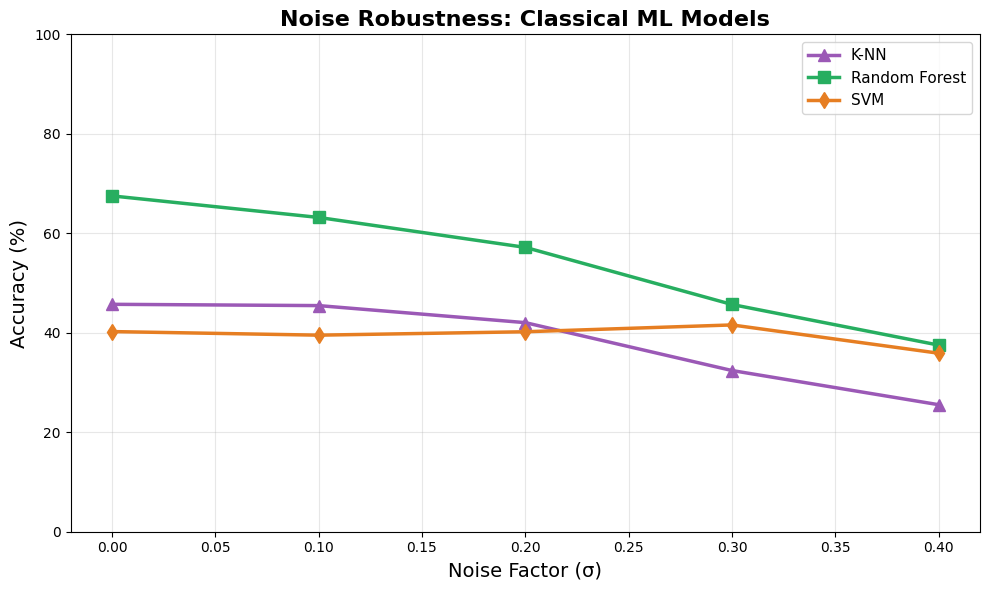

✅ Graph saved to /content/noise_robustness_classical.png

✅ CLASSICAL MODELS NOISE TEST COMPLETE!

🔍 Quick Analysis:
   🏆 Most Robust: SVM (drop: 4.35%)
   ⚠️  Least Robust: Random Forest (drop: 30.00%)


In [15]:
# =============================================================================
# 🌪️ NOISE ROBUSTNESS TEST - CLASSICAL BASELINE MODELS (K-NN, RF, SVM)
# =============================================================================
# This cell tests how classical ML models perform under different levels of
# Gaussian noise, enabling fair comparison with deep learning models.
# =============================================================================

print("="*70)
print("🌪️ NOISE ROBUSTNESS TEST (Classical Baseline Models)")
print("="*70)

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Configuration
NOISE_LEVELS = [0.0, 0.1, 0.2, 0.3, 0.4]
VAL_DIR = '/content/dataset/val'
TRAIN_DIR = '/content/dataset/train'
IMG_SIZE = 64

# =============================================================================
# Helper Function: Load Data with Noise
# =============================================================================
def load_data_with_noise(data_dir, img_size=64, noise_factor=0.0):
    """Load and flatten images with added Gaussian noise for classical ML"""
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for label_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                # Normalize to 0-1, add noise, clip back
                img = img.astype(np.float32) / 255.0
                if noise_factor > 0:
                    noise = np.random.randn(*img.shape) * noise_factor
                    img = np.clip(img + noise, 0, 1)
                img = (img * 255).astype(np.uint8)
                images.append(img.flatten())
                labels.append(label_idx)

    return np.array(images), np.array(labels)

# =============================================================================
# Step 1: Load Clean Training Data & Train Models
# =============================================================================
print("\n📂 Loading clean training data...")
X_train_clean, y_train = load_data_with_noise(TRAIN_DIR, IMG_SIZE, noise_factor=0.0)
print(f"   ✅ Training data shape: {X_train_clean.shape}")

# Fit preprocessor on clean data
print("\n⚙️ Fitting PCA preprocessor (12,288 → 100 features)...")
preprocessor = make_pipeline(StandardScaler(), PCA(n_components=100))
X_train_reduced = preprocessor.fit_transform(X_train_clean)

# Train classical models on clean data
print("\n🔄 Training classical models on clean data...")
classical_models = {
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": LinearSVC(dual='auto', max_iter=5000, random_state=42)
}

for name, model in classical_models.items():
    model.fit(X_train_reduced, y_train)
    print(f"   ✅ {name} trained")

# =============================================================================
# Step 2: Test Models Across Noise Levels
# =============================================================================
print("\n" + "-"*70)
print("🧪 Testing classical models across noise levels...")
print("-"*70)

classical_noise_results = {name: [] for name in classical_models.keys()}

for noise in tqdm(NOISE_LEVELS, desc="📊 Noise Levels"):
    # Load validation data with noise
    X_val_noisy, y_val = load_data_with_noise(VAL_DIR, IMG_SIZE, noise_factor=noise)
    X_val_reduced = preprocessor.transform(X_val_noisy)

    for name, model in classical_models.items():
        y_pred = model.predict(X_val_reduced)
        acc = accuracy_score(y_val, y_pred) * 100
        classical_noise_results[name].append(acc)

# =============================================================================
# Step 3: Display Results Table
# =============================================================================
print("\n" + "="*70)
print("📊 CLASSICAL MODELS - NOISE ROBUSTNESS RESULTS")
print("="*70)

# Print header
header = "{:<20}".format("Model")
for noise in NOISE_LEVELS:
    header += "{:>12}".format(f"σ={noise}")
header += "{:>15}".format("Drop (0→0.4)")
print(header)
print("-"*95)

# Print results
for name, accs in classical_noise_results.items():
    row = "{:<20}".format(name)
    for acc in accs:
        row += "{:>12}".format(f"{acc:.2f}%")
    drop = accs[0] - accs[-1]
    row += "{:>15}".format(f"-{drop:.2f}%")
    print(row)

print("-"*95)

# =============================================================================
# Step 4: Plot Classical Models Noise Robustness
# =============================================================================
print("\n📈 Generating Classical Models Robustness Graph...")

plt.figure(figsize=(10, 6))

# Define colors and styles
style_config = {
    "K-NN": {"color": "#9b59b6", "linestyle": "-", "marker": "^"},
    "Random Forest": {"color": "#27ae60", "linestyle": "-", "marker": "s"},
    "SVM": {"color": "#e67e22", "linestyle": "-", "marker": "d"},
}

for name, accs in classical_noise_results.items():
    style = style_config[name]
    plt.plot(NOISE_LEVELS, accs,
             color=style["color"],
             linestyle=style["linestyle"],
             marker=style["marker"],
             linewidth=2.5,
             markersize=8,
             label=name)

plt.xlabel('Noise Factor (σ)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Noise Robustness: Classical ML Models', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(-0.02, 0.42)
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('/content/noise_robustness_classical.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Graph saved to /content/noise_robustness_classical.png")

# =============================================================================
# Step 5: Store Results for Combined Comparison
# =============================================================================
# Save results to global variable for combined plotting
CLASSICAL_NOISE_RESULTS = classical_noise_results.copy()

print("\n" + "="*70)
print("✅ CLASSICAL MODELS NOISE TEST COMPLETE!")
print("="*70)

# Quick comparison
print("\n🔍 Quick Analysis:")
drops = {name: accs[0] - accs[-1] for name, accs in classical_noise_results.items()}
most_robust = min(drops, key=drops.get)
least_robust = max(drops, key=drops.get)
print(f"   🏆 Most Robust: {most_robust} (drop: {drops[most_robust]:.2f}%)")
print(f"   ⚠️  Least Robust: {least_robust} (drop: {drops[least_robust]:.2f}%)")

📊 COMBINED NOISE ROBUSTNESS COMPARISON
   Classical ML vs Deep Learning Models
✅ Classical model results loaded
✅ Deep learning model results loaded

📊 Total models to compare: 8

----------------------------------------------------------------------
📈 Generating Combined Robustness Comparison Graph...
----------------------------------------------------------------------


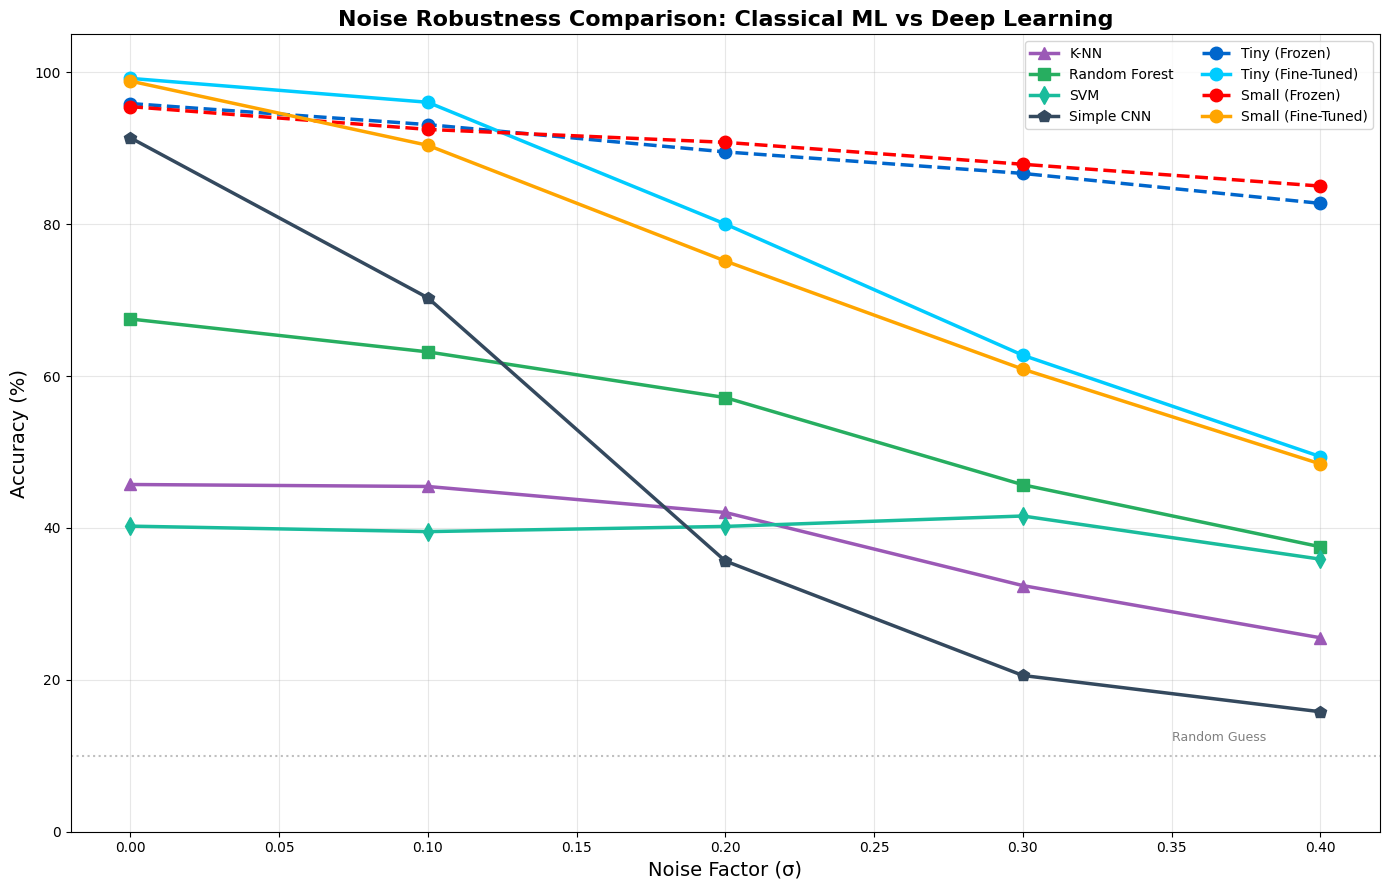


✅ Combined graph saved to /content/noise_robustness_all_models.png

📊 COMPREHENSIVE NOISE ROBUSTNESS TABLE
Model                         σ=0.0     σ=0.1     σ=0.2     σ=0.3     σ=0.4        Drop      Type
----------------------------------------------------------------------------------------------------
Tiny (Fine-Tuned)             99.2%     96.1%     80.0%     62.7%     49.4%      -49.8%  ConvNeXt
Small (Fine-Tuned)            98.9%     90.4%     75.1%     60.9%     48.4%      -50.4%  ConvNeXt
Tiny (Frozen)                 95.9%     93.1%     89.5%     86.7%     82.7%      -13.1%  ConvNeXt
Small (Frozen)                95.5%     92.5%     90.8%     87.9%     85.0%      -10.5%  ConvNeXt
Simple CNN                    91.4%     70.3%     35.6%     20.6%     15.8%      -75.6%       CNN
Random Forest                 67.5%     63.2%     57.2%     45.7%     37.5%      -30.0% Classical
K-NN                          45.7%     45.5%     42.0%     32.4%     25.5%      -20.2% Classical
SVM    

In [16]:
# =============================================================================
# 📊 COMBINED NOISE ROBUSTNESS COMPARISON (All Models)
# =============================================================================
# This cell creates a combined visualization comparing noise robustness
# of ALL models: Classical ML (K-NN, RF, SVM) vs Deep Learning (CNN, ConvNeXt)
#
# ⚠️ RUN THIS AFTER: Classical baseline noise test AND Deep learning noise test
# =============================================================================

print("="*70)
print("📊 COMBINED NOISE ROBUSTNESS COMPARISON")
print("   Classical ML vs Deep Learning Models")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np

# Noise levels (must match previous cells)
NOISE_LEVELS = [0.0, 0.1, 0.2, 0.3, 0.4]

# =============================================================================
# Collect Results from Previous Cells
# =============================================================================
# Note: These variables should exist from running previous noise test cells
# - CLASSICAL_NOISE_RESULTS: from classical baseline noise test
# - noise_results: from deep learning noise test

# Check if results exist
try:
    all_results = {}

    # Add classical results
    if 'CLASSICAL_NOISE_RESULTS' in dir():
        all_results.update(CLASSICAL_NOISE_RESULTS)
        print("✅ Classical model results loaded")
    elif 'classical_noise_results' in dir():
        all_results.update(classical_noise_results)
        print("✅ Classical model results loaded")
    else:
        print("⚠️ Classical results not found - run classical noise test first!")

    # Add deep learning results
    if 'noise_results' in dir():
        all_results.update(noise_results)
        print("✅ Deep learning model results loaded")
    else:
        print("⚠️ Deep learning results not found - run DL noise test first!")

    print(f"\n📊 Total models to compare: {len(all_results)}")

except Exception as e:
    print(f"❌ Error loading results: {e}")

# =============================================================================
# Combined Visualization
# =============================================================================
print("\n" + "-"*70)
print("📈 Generating Combined Robustness Comparison Graph...")
print("-"*70)

fig, ax = plt.subplots(figsize=(14, 9))

# Define colors and styles for ALL models
style_config = {
    # Classical ML (solid lines, different markers)
    "K-NN": {"color": "#9b59b6", "linestyle": "-", "marker": "^", "linewidth": 2.5, "group": "Classical"},
    "Random Forest": {"color": "#27ae60", "linestyle": "-", "marker": "s", "linewidth": 2.5, "group": "Classical"},
    "SVM": {"color": "#1abc9c", "linestyle": "-", "marker": "d", "linewidth": 2.5, "group": "Classical"},

    # Simple CNN
    "Simple CNN": {"color": "#34495e", "linestyle": "-", "marker": "p", "linewidth": 2.5, "group": "Simple DL"},

    # ConvNeXt Frozen (dashed lines)
    "Tiny (Frozen)": {"color": "#0066CC", "linestyle": "--", "marker": "o", "linewidth": 2.5, "group": "ConvNeXt"},
    "Small (Frozen)": {"color": "#FF0000", "linestyle": "--", "marker": "o", "linewidth": 2.5, "group": "ConvNeXt"},

    # ConvNeXt Fine-Tuned (solid lines)
    "Tiny (Fine-Tuned)": {"color": "#00CCFF", "linestyle": "-", "marker": "o", "linewidth": 2.5, "group": "ConvNeXt"},
    "Small (Fine-Tuned)": {"color": "#FFA500", "linestyle": "-", "marker": "o", "linewidth": 2.5, "group": "ConvNeXt"},
}

# Plot each model
for model_name, accuracies in all_results.items():
    if model_name in style_config:
        style = style_config[model_name]
    else:
        # Default style for unknown models
        style = {"color": "gray", "linestyle": "-", "marker": "x", "linewidth": 2}

    ax.plot(NOISE_LEVELS, accuracies,
            color=style["color"],
            linestyle=style["linestyle"],
            marker=style["marker"],
            linewidth=style["linewidth"],
            markersize=9,
            label=model_name)

ax.set_xlabel('Noise Factor (σ)', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Noise Robustness Comparison: Classical ML vs Deep Learning',
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 0.42)
ax.set_ylim(0, 105)

# Add reference line
ax.axhline(y=10, color='gray', linestyle=':', alpha=0.5)
ax.text(0.35, 12, 'Random Guess', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('/content/noise_robustness_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Combined graph saved to /content/noise_robustness_all_models.png")

# =============================================================================
# Comprehensive Results Table
# =============================================================================
print("\n" + "="*70)
print("📊 COMPREHENSIVE NOISE ROBUSTNESS TABLE")
print("="*70)

# Sort by accuracy at σ=0 (clean data)
sorted_results = sorted(all_results.items(), key=lambda x: x[1][0], reverse=True)

# Print header
header = "{:<25}".format("Model")
for noise in NOISE_LEVELS:
    header += "{:>10}".format(f"σ={noise}")
header += "{:>12}".format("Drop")
header += "{:>10}".format("Type")
print(header)
print("-"*100)

# Determine model type
def get_model_type(name):
    if name in ["K-NN", "Random Forest", "SVM"]:
        return "Classical"
    elif name == "Simple CNN":
        return "CNN"
    else:
        return "ConvNeXt"

# Print results
for name, accs in sorted_results:
    row = "{:<25}".format(name)
    for acc in accs:
        row += "{:>10}".format(f"{acc:.1f}%")
    drop = accs[0] - accs[-1]
    row += "{:>12}".format(f"-{drop:.1f}%")
    row += "{:>10}".format(get_model_type(name))
    print(row)

print("-"*100)

# =============================================================================
# Key Insights
# =============================================================================
print("\n" + "="*70)
print("🔍 KEY INSIGHTS: Classical vs Deep Learning Robustness")
print("="*70)

# Calculate statistics
classical_models = ["K-NN", "Random Forest", "SVM"]
dl_models = [k for k in all_results.keys() if k not in classical_models]

classical_drops = [all_results[m][0] - all_results[m][-1] for m in classical_models if m in all_results]
dl_drops = [all_results[m][0] - all_results[m][-1] for m in dl_models if m in all_results]

if classical_drops:
    avg_classical_drop = np.mean(classical_drops)
    print(f"\n📊 Classical ML Models:")
    print(f"   - Average accuracy drop (σ=0 → σ=0.4): {avg_classical_drop:.2f}%")
    print(f"   - Most robust: {classical_models[np.argmin(classical_drops)]}")

if dl_drops:
    avg_dl_drop = np.mean(dl_drops)
    print(f"\n🧠 Deep Learning Models:")
    print(f"   - Average accuracy drop (σ=0 → σ=0.4): {avg_dl_drop:.2f}%")
    most_robust_dl = dl_models[np.argmin(dl_drops)] if dl_drops else "N/A"
    least_robust_dl = dl_models[np.argmax(dl_drops)] if dl_drops else "N/A"
    print(f"   - Most robust: {most_robust_dl}")
    print(f"   - Least robust: {least_robust_dl}")

if classical_drops and dl_drops:
    print(f"\n⚖️ Comparison:")
    if avg_classical_drop < avg_dl_drop:
        print(f"   ✅ Classical models are MORE robust to noise!")
        print(f"   - Classical avg drop: {avg_classical_drop:.2f}%")
        print(f"   - Deep Learning avg drop: {avg_dl_drop:.2f}%")
        print(f"   - Difference: {avg_dl_drop - avg_classical_drop:.2f}%")
    else:
        print(f"   ✅ Deep Learning models are MORE robust to noise!")
        print(f"   - Deep Learning avg drop: {avg_dl_drop:.2f}%")
        print(f"   - Classical avg drop: {avg_classical_drop:.2f}%")

# Frozen vs Fine-tuned comparison
frozen_models = [k for k in all_results.keys() if "Frozen" in k]
finetuned_models = [k for k in all_results.keys() if "Fine-Tuned" in k]

if frozen_models and finetuned_models:
    frozen_drops = [all_results[m][0] - all_results[m][-1] for m in frozen_models]
    finetuned_drops = [all_results[m][0] - all_results[m][-1] for m in finetuned_models]

    print(f"\n❄️ Frozen vs 🔥 Fine-Tuned ConvNeXt:")
    print(f"   - Frozen avg drop: {np.mean(frozen_drops):.2f}%")
    print(f"   - Fine-Tuned avg drop: {np.mean(finetuned_drops):.2f}%")

    if np.mean(frozen_drops) < np.mean(finetuned_drops):
        print(f"   ✅ Frozen models are MORE robust (but lower peak accuracy)")
    else:
        print(f"   ✅ Fine-Tuned models are MORE robust")

print("\n" + "="*70)
print("✅ COMBINED ANALYSIS COMPLETE!")
print("="*70)

📸 Generating visualization for: AnnualCrop_2199.jpg


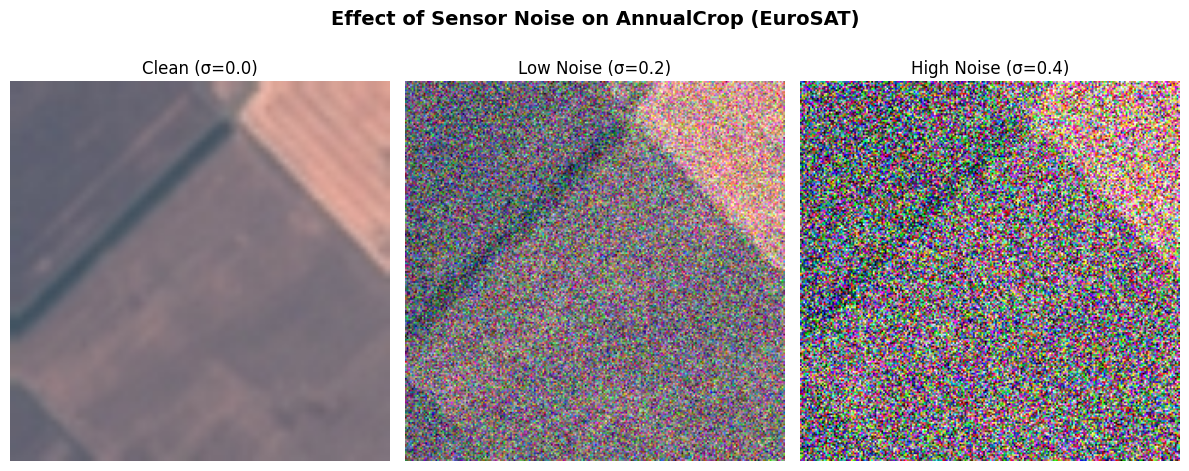

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import random
from torchvision import transforms
from PIL import Image

# --- Configuration ---
# EXACT Sigma values from your Demo/Report
NOISE_LEVELS_FOR_VIS = [0.0, 0.2, 0.4]
CLASS_TO_VISUALIZE = 'AnnualCrop'  # Change to 'Forest', 'River', etc. if desired

# --- Locate Validation Images ---
# Tries to find the specific class folder in the validation set
val_class_dir = os.path.join(VAL_DIR, CLASS_TO_VISUALIZE)
if not os.path.exists(val_class_dir):
    # Fallback: Find the class in the source directory if val doesn't exist separately
    print(f"⚠️ Note: '{CLASS_TO_VISUALIZE}' not found in VAL_DIR. Searching in data root...")
    extracted_root = os.path.join(DATA_DIR, [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and d != 'train' and d != 'val'][0])
    val_class_dir = os.path.join(extracted_root, CLASS_TO_VISUALIZE)

# 1. Pick a random image
image_files = [f for f in os.listdir(val_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image_file = random.choice(image_files)
image_path = os.path.join(val_class_dir, random_image_file)

# 2. Define Transform (Resize only, No Normalization yet)
# We want to visualize the actual pixels, so we don't normalize to ImageNet stats here.
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Image
original_img_tensor = img_transform(Image.open(image_path))

# 3. Noise Function
def get_noisy_image(img_tensor, sigma):
    """Adds Gaussian noise and prepares for plotting."""
    if sigma == 0.0:
        noisy_tensor = img_tensor
    else:
        # Add additive Gaussian noise
        noise = torch.randn_like(img_tensor) * sigma
        noisy_tensor = img_tensor + noise

    # Clip to valid pixel range [0, 1]
    noisy_tensor = torch.clamp(noisy_tensor, 0.0, 1.0)

    # Convert to Numpy (Height, Width, Channel) for Matplotlib
    img_np = noisy_tensor.permute(1, 2, 0).numpy()
    return img_np

# 4. Generate Plot
fig, axes = plt.subplots(1, len(NOISE_LEVELS_FOR_VIS), figsize=(12, 5))
fig.suptitle(f'Effect of Sensor Noise on {CLASS_TO_VISUALIZE} (EuroSAT)', fontsize=14, fontweight='bold')

for i, sigma in enumerate(NOISE_LEVELS_FOR_VIS):
    noisy_img = get_noisy_image(original_img_tensor, sigma)

    # Label matching your report terms
    if sigma == 0.0:
        label = f"Clean (σ={sigma})"
    elif sigma == 0.2:
        label = f"Low Noise (σ={sigma})"
    else:
        label = f"High Noise (σ={sigma})"

    axes[i].imshow(noisy_img)
    axes[i].set_title(label, fontsize=12)
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print(f"📸 Generating visualization for: {random_image_file}")
plt.show()